In [1]:
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbn
import datetime as dt
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm, trange

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda')

In [3]:
class MyNet(nn.Module):

    def __init__(self, w_layers, pred_layers):

        super().__init__()
              
        # Weaher variables
        w_layers_list = nn.ModuleList()
        for i, o, k, d in w_layers:
            w_layer = nn.Sequential(
                nn.Conv1d(i, o, k),
                nn.AvgPool1d(2),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            w_layers_list.append(w_layer)
        w_layers_list.append(nn.AdaptiveAvgPool1d(1))
        self.w_layers = nn.Sequential(*w_layers_list)

        
        # Management variables
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws):
        
        feat = self.w_layers(Ws).view(Ws.shape[0], -1)
        pred = self.pred_layers(feat)
        return (torch.tanh(pred))


In [4]:
def transform(w):
    ws = np.array([[[5e4,50,50,5,10,100]]])
    w = w / ws
    w = np.moveaxis(w, 1, 2)
    wd = np.linspace(-0.9,2.1,300)[None,None]
    wd = wd.repeat(len(w), 0)
    w = np.concatenate([w, wd], 1)
    w = torch.tensor(w, dtype=torch.float, device = device)
    return(w)

def back_transform(w):
    w = w[:,:6].cpu().data.numpy()
    w = np.moveaxis(w, 2, 1)
    ws = np.array([[[5e4,50,50,5,10,100]]])
    w = w * ws
    return(w[0])


def get_adv(x, eps = 1):
    xo = x.clone()
    x.requires_grad = True

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam([x], lr=0.01)

    for i in range(10):

        # Limpa os gradientes
        optimizer.zero_grad()

        # Obtem o output
        outputs = model(x)

        # Caulcula a perda pela loss function
        loss = -outputs.mean()

        # Use an l2 penalty:
        loss += criterion(xo, x)/eps

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        # Clip to the valid range of values:
        x.data = torch.clamp(x.data, 0, 1)
        x.data[:,-1] = xo[:,-1]

    return(x)

In [13]:
d = 0.0
w_layers =  [[7,12,3,d],[12,15,5,d],[15,20,7,d],[20,25,5,d],[25,100,3,d]]
pred_layers = [[100,50,d],[50,50,d], [50,25,d]]

model = MyNet(w_layers, pred_layers)
model = model.to(device)
    
model_file_name = '../data/model_cnn_rnd01.pth'
model.load_state_dict(torch.load(model_file_name, map_location=device))
model.eval()
print('Model OK')

Model OK


In [14]:
pts = gpd.read_file('../../CIAT/data/BEM_2019_Chiapas_Final_Clean.gpkg')
pts['SIM'] = ['CH{0:05d}'.format(i + 1) for i in range(len(pts))]
pts = pts.set_index('SIM')
pts['ref_date'] = pd.to_datetime(pts.fecha_de_siembra)
SIM = pts.index

In [15]:
# yl = []
# for i, key in enumerate(tqdm(SIM)):
#     crop_start_date = pts.ref_date.dt.date.loc[key]
#     sim_start_date = crop_start_date - dt.timedelta(days = 90)
#     crop_end_date = crop_start_date + dt.timedelta(days = 210)
    
#     wfile = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE/{key}_npff.csv'
#     w = pd.read_csv(wfile, skiprows=13)
#     w.DAY = pd.to_datetime(w.DAY, format= '%Y%m%d').dt.date
#     ini_idx = np.where(w.DAY == sim_start_date)[0][0]
#     end_idx = np.where(w.DAY == crop_end_date)[0][0]
#     s_idx = slice(ini_idx, end_idx)
#     w_seed = w[s_idx].values[:,1:-1].astype('float')
#     w_seed = transform(w_seed)
#     y_pred = model(w_seed).data.cpu().numpy()
#     w_adv = get_adv(w_seed, 0.01)
#     y_adv = model(w_adv).data.cpu().numpy()
#     w_adv = back_transform(w_adv)
#     yl.append([y_pred, y_adv])

#     dff = w.iloc[s_idx].copy()
#     dff.iloc[:,1:-1] = w_adv
    
#     save_file = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE/{key}_adv000.csv'
#     with open(save_file, 'w') as sf:
#         with open(wfile) as f:
#             for r in range(14):
#                 sf.writelines(f.readline())
    
#     dff.DAY = pd.to_datetime(dff.DAY).dt.strftime('%Y%m%d')
#     dff.to_csv(save_file, na_rep = 'NaN', mode = 'a', float_format = '%.3f', header = False, index = False)


In [16]:
yl = []
for i, key in enumerate(tqdm(SIM)):
    wfile = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE/{key}_npff.csv'
    w = pd.read_csv(wfile, skiprows=13)
    w_seed = w.values[:,1:-1].astype('float')
    w_seed = transform(w_seed)
    y_pred = model(w_seed).data.cpu().numpy()
    w_adv = get_adv(w_seed, 0.01)
    y_adv = model(w_adv).data.cpu().numpy()
    w_adv = back_transform(w_adv)
    yl.append([y_pred, y_adv])

    w.iloc[:,1:-1] = w_adv
    w.VAP = np.clip(w.VAP, 0.06, 199.3)
    
    save_file = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE/{key}_adv010.csv'
    with open(save_file, 'w') as sf:
        with open(wfile) as f:
            for r in range(14):
                sf.writelines(f.readline())
    
    w.DAY = w.DAY.astype('str')
    w.to_csv(save_file, na_rep = 'NaN', mode = 'a', float_format = '%.3f', header = False, index = False)


In [17]:
ynp = 2e4 * np.array(yl)[:,:,0,0]

(array([ 101.,  354., 1003., 1098.,  890.,  605.,  329.,   57.,   83.,
          74.]),
 array([ 752.6631, 1197.4076, 1642.1521, 2086.8965, 2531.641 , 2976.3855,
        3421.13  , 3865.8745, 4310.619 , 4755.3633, 5200.108 ],
       dtype=float32),
 <a list of 10 Patch objects>)

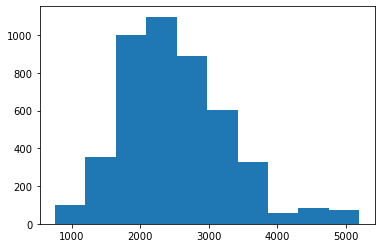

In [18]:
plt.hist(np.diff(ynp, 1))

([array([ 101.,  387., 1205., 1472.,  635.,  243.,  451.,  100.,    0.,
            0.]),
  array([   0.,    0.,    0.,   93.,  178.,  262.,  810., 1020., 1181.,
         1050.])],
 array([ 8024.278,  8634.938,  9245.599,  9856.259, 10466.919, 11077.579,
        11688.239, 12298.9  , 12909.561, 13520.221, 14130.881],
       dtype=float32),
 <a list of 2 Lists of Patches objects>)

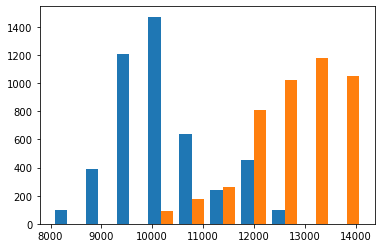

In [19]:
plt.hist(ynp)

In [20]:
np.save('../data/y_pred_adv010.npy', ynp)